前面一章，实现了通过数值微分，求神经网络的损失函数对权重参数的梯度，这种方式很容易实现，但是缺点是计算比较费时间

## 计算图的反向传播

现在有一个 $y=f(x)$ 的计算

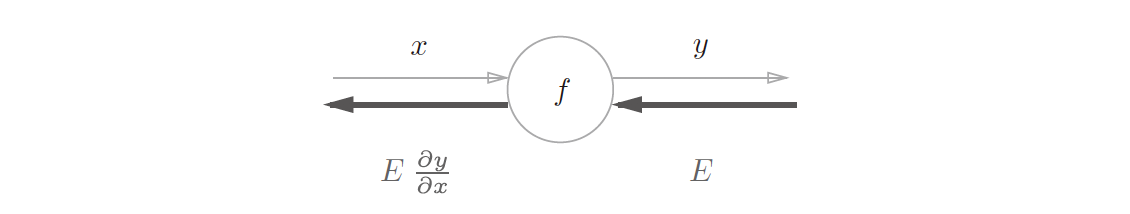

反向传播的计算顺序是，将信号E乘以节点的局部导数 $\frac{\partial y}{\partial x}$，然后将结果传递给下一个节点。这里所说的局部导数是指正向传播
中 $y = f(x)$ 的导数，也就是 $y$ 关于 $x$ 的导数 $\frac{\partial y}{\partial x}$

## 链式法则

**复合函数** 是由多个函数构成的函数，如下面函数 $z=(x+y)^{2}$：$$z=t^{2}$$ $$t=x+y$$

链式法则是关于复合函数的导数的性质，定义如下。

> 如果某个函数由复合函数表示，则该复合函数的导数可以用构成复合函数的各个函数的导数的乘积表示。

就上面的复合函数 $z$ 举例，$$\frac{\partial z}{\partial x}=\frac{\partial z}{\partial t} \frac{\partial t}{\partial x}$$